In this project, we are going to do a cat versus dog classification. All the train and test data come from the Kaggle dataset. We will use two ways to do this classification, CNN model training and transfer learning.

# Part One Covolutional Neural Network

 First, we will use Covolutional Nueral Network to train the model.

The first step is data preprocessing. These are all imports and constants we need for preprocessing. The two directions are where I save my data.

In [5]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion

TRAIN_DIR = 'dogs-vs-cats-redux-kernels-edition\\train'
TEST_DIR = 'dogs-vs-cats-redux-kernels-edition\\test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

The origianl test images have been labeled for us as dog or cat. However, it is not useful because we need one-hot array so that these data can be fed to the CNN model. What we have done here is use this label_img function to convert labels to number.

In [13]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

Then, with function create train data, we can resize and grayscale training images.

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

Then, we can do the same way to test images, the only difference is that they are not labeled.

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

Now, we can get the training data which is suitable to our CNN model.

In [5]:
# train_data = create_train_data()
# If you have already created the dataset:
train_data = np.load('train_data.npy')

The second step is Convolutional Neural Network.

Here are the imports we need for training model. Actually, tflearn provides us a conveninent way to define CNN model.

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

Instructions for updating:
Colocations handled automatically by placer.


First, I tried a three-hidden layer neural network with 2 epochs. But the accuracy is not good. So I will define a new 7-hidden layer CNN model here. And thus, before we do it, we have to reset it.

In [7]:
import tensorflow as tf
tf.reset_default_graph()

Here is a 7-hidden layer neural network with 8 epochs. I use relu activate function and max pooling. Softmax is for classifying. Note here that I use the last 500 images as test data. This test data is different with the test images, which are not labeled. These 500 images are used to test the accuracy of this model. That is, we need some labeled images to help us test classification model. Here, X and Y are training data, which is for fit the model. And test x and test y are what for test model.

In [8]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=8, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3063  | total loss: 0.34618 | time: 5.411s
| Adam | epoch: 008 | loss: 0.34618 - acc: 0.8417 -- iter: 24448/24500
Training Step: 3064  | total loss: 0.35786 | time: 6.425s
| Adam | epoch: 008 | loss: 0.35786 - acc: 0.8341 | val_loss: 0.54880 - val_acc: 0.7640 -- iter: 24500/24500
--


Another thing is the run id in model fit, this is how we find our model. After training, we can see that the accuracy is 83.41%. It looks good.

Using model save, we can simply save the whole model including all parameters the optimization progress has tune. If we want to continue the training, all we need to do is just load this model and repeat what we have done here. In this case, we don’t have to train our networks fresh every time.



In [9]:
model.save(MODEL_NAME)

INFO:tensorflow:D:\NU_Courses\2019winter\EECS-435\Final Project\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


The third step is classification. With our test images, we can test this model by eyes. Here I only plot the first 25 images in the dataset.

<IPython.core.display.Javascript object>


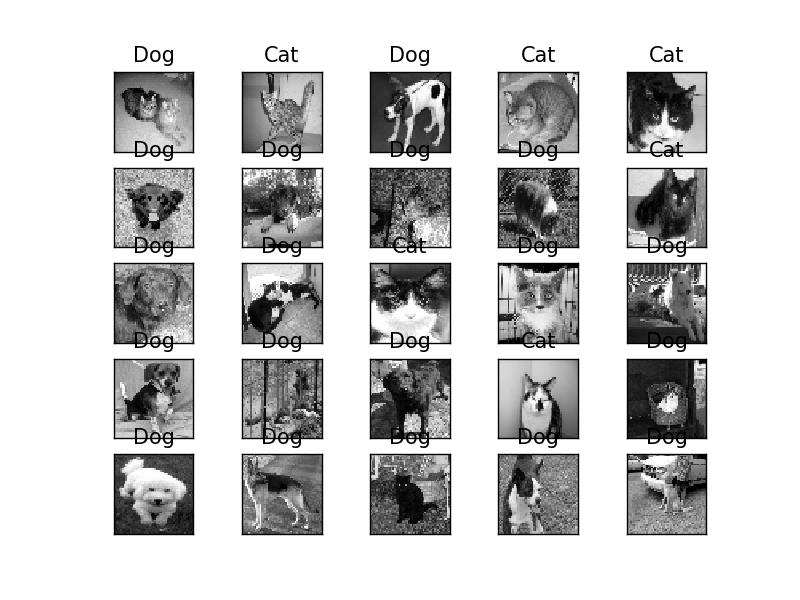

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook

# if you need to create the data:
# test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:25]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(5,5,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

It seems like only two of them are wrong. Well, it does make some mistakes, but not too bad!

# Part 2 Transfer Learning

In [14]:
import pandas as pd
# Output = pd.DataFrame({'id': np.arange(test_data.shape[0]), 'label': np.zeros(test_data.shape[0])})
im_id = []
im_label = []
for num,data in enumerate(test_data[:]):
    # cat: [1,0]
    # dog: [0,1]
    
    im_id.append(int(data[1]))
    img_data = data[0]
    
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    im_label.append(model_out[1])

In [15]:
import pandas as pd
Output = pd.DataFrame({'id':im_id, 'label': im_label})
Output = Output.sort_values('id')
Output.to_csv('results.csv', index = False)

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import Model
from keras import initializers
from keras.callbacks import EarlyStopping, TensorBoard
from keras.applications.vgg16 import VGG16
import os 

Using TensorFlow backend.


## Define ImageGenerator

In [4]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale=1/255., validation_split= 0.2)

input_shape = (224,224,3)

BATCH_SIZE = 10

TRAIN_DIR = 'dogs-vs-cats-redux-kernels-edition\\train'
TEST_DIR = 'dogs-vs-cats-redux-kernels-edition\\test'

# training set
train_generator = train_datagen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = input_shape[:-1],
    color_mode = 'rgb',
    classes = None,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    subset='training')

# validation set
validation_generator = train_datagen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = input_shape[:-1],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'categorical',
    subset = 'validation')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Load Pre-Trained VGG16

In [5]:
vgg16 = VGG16(input_shape = input_shape, 
                     include_top = True, 
                     classes = 1000, 
                     weights = 'imagenet'
                     )

print('Model loaded.')

Instructions for updating:
Colocations handled automatically by placer.
Model loaded.


## Construct Networks Based on VGG16

In [6]:
model = Sequential()
# add pre-trained model and set it to be untrainable
model.add(vgg16)
model.layers[0].trainable = False
# add fully connected layers to be fine-tuned with our dogs&cats data
model.add(Dense(256, activation = 'relu', kernel_initializer='glorot_uniform'))
model.add(Dense(2, activation = 'softmax', kernel_initializer='glorot_uniform'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1000)              138357544 
_________________________________________________________________
dense_1 (Dense)              (None, 256)               256256    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 138,614,314
Trainable params: 256,770
Non-trainable params: 138,357,544
_________________________________________________________________


## Train the Model

In [7]:
# define optimizer
# sgd = optimizers.SGD(lr = 0.1, decay = 1e-6, momentum = 0.9, nesterov = True)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# use early stopping to avoid overfitting
stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
                 write_graph=True,  # 是否存储网络结构图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None,
                 update_freq=100
                )

# fine-tune the model
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples/BATCH_SIZE,
        epochs = 10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples/BATCH_SIZE,
        callbacks = [stop, tbCallBack]
)

# save trained weights
model.save_weights('fine_tuned_net.h5')

# os.system('shutdown -s -t 1')

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2000/2000 [==============================] - 193s 96ms/step - loss: 0.5181 - acc: 0.7465 - val_loss: 0.4148 - val_acc: 0.8224
Epoch 2/10
2000/2000 [==============================] - 197s 99ms/step - loss: 0.3786 - acc: 0.8363 - val_loss: 0.3494 - val_acc: 0.8472
Epoch 3/10
2000/2000 [==============================] - 199s 99ms/step - loss: 0.3370 - acc: 0.8550 - val_loss: 0.3126 - val_acc: 0.8670
Epoch 4/10
2000/2000 [==============================] - 200s 100ms/step - loss: 0.3198 - acc: 0.8632 - val_loss: 0.3083 - val_acc: 0.8736
Epoch 5/10
2000/2000 [==============================] - 194s 97ms/step - loss: 0.3080 - acc: 0.8679 - val_loss: 0.2965 - val_acc: 0.8788
Epoch 6/10
2000/2000 [==============================] - 200s 100ms/step - loss: 0.2980 - acc: 0.8717 - val_loss: 0.2828 - val_acc: 0.8790
Epoch 7/10
2000/2000 [==============================] - 199s 100ms/step - loss: 0.2926 - acc: 0.8747 - val_loss: 0.2768 - val_ac

## Summary of Training Metrics

<IPython.core.display.Javascript object>


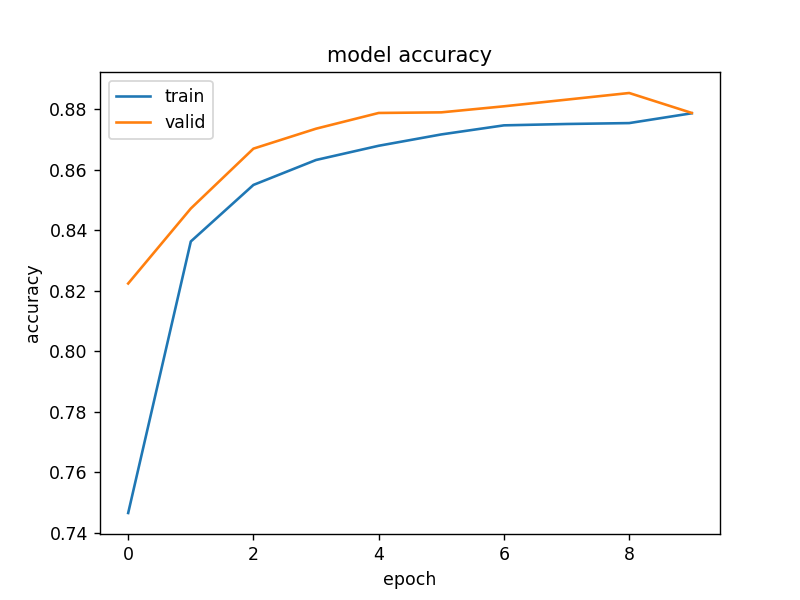

<IPython.core.display.Javascript object>


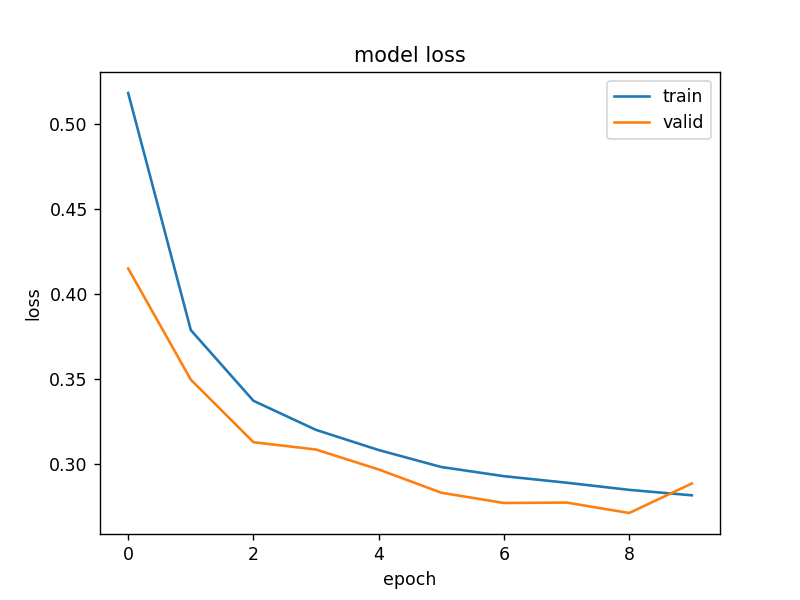

In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure()  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.figure()
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

## Predict Test Set

In [43]:
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory(
    directory = TEST_DIR,
    target_size = input_shape[:-1],
    batch_size = BATCH_SIZE,
    class_mode = None,
    shuffle = False
)

Found 12500 images belonging to 1 classes.


In [45]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = test_generator.samples/BATCH_SIZE, verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

1250/1250 [==============================] - 102s 82ms/step


<IPython.core.display.Javascript object>


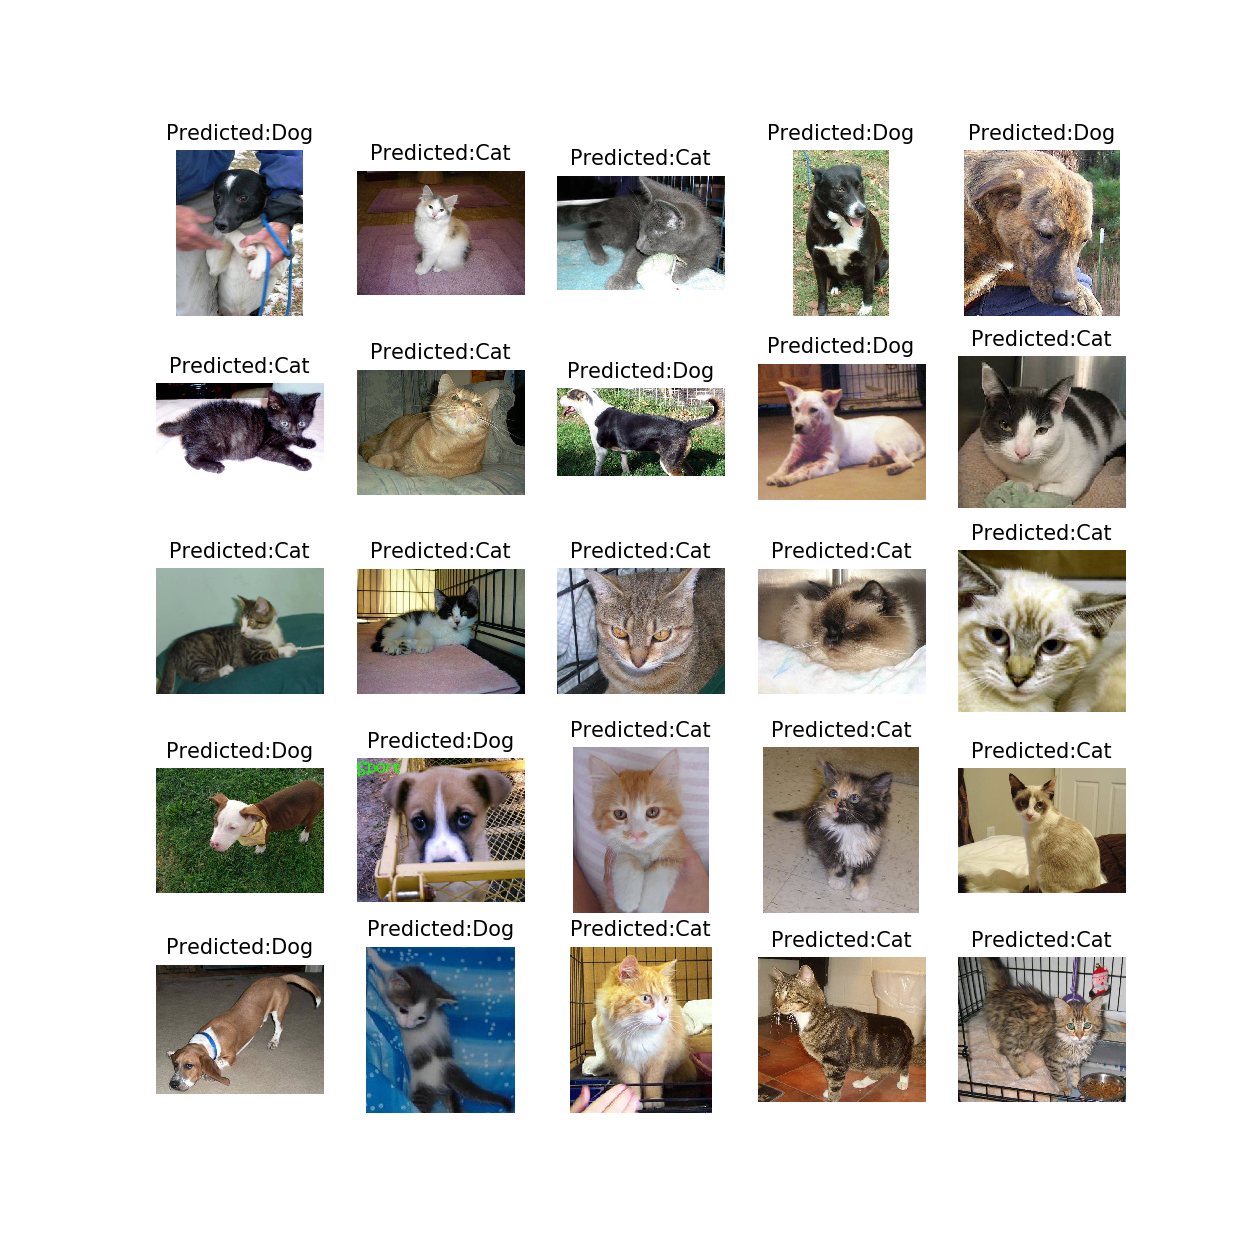

In [47]:
import cv2  

f, ax = plt.subplots(5, 5, figsize = (10, 10))

for i in range(0,25):
    imgBGR = cv2.imread(TEST_DIR + '\\'+ test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "Dog" if predicted_class_indices[i] else "Cat"

    ax[i//5, i%5].imshow(imgRGB)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

plt.show()

In [57]:
import pandas as pd

results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(pred[:,1])
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)

results_df.to_csv('submission.csv', index=False)
results_df.head()

,id,label
0,1,0.934320
3612,2,0.999992
4723,3,0.999204
5834,4,0.998147
6945,5,0.078514


# References

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

https://www.kaggle.com/c/dogs-vs-cats

https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50